Found 1 image files

Processing: 20211222_125057_petiole4_00012.tiff
Object mask shape: (2560, 2560)
Number of unique objects: 2084

Number of classes: 6
Classes found: ['0', '1', '2', '3', '4', '5']

Creating class regions...
Class 0: Region area = 169380 pixels
Class 1: Region area = 534015 pixels
Class 2: Region area = 31850 pixels
Class 3: Region area = 690068 pixels
Class 4: Region area = 887361 pixels
Class 5: Region area = 1066993 pixels

Visualizing class regions...


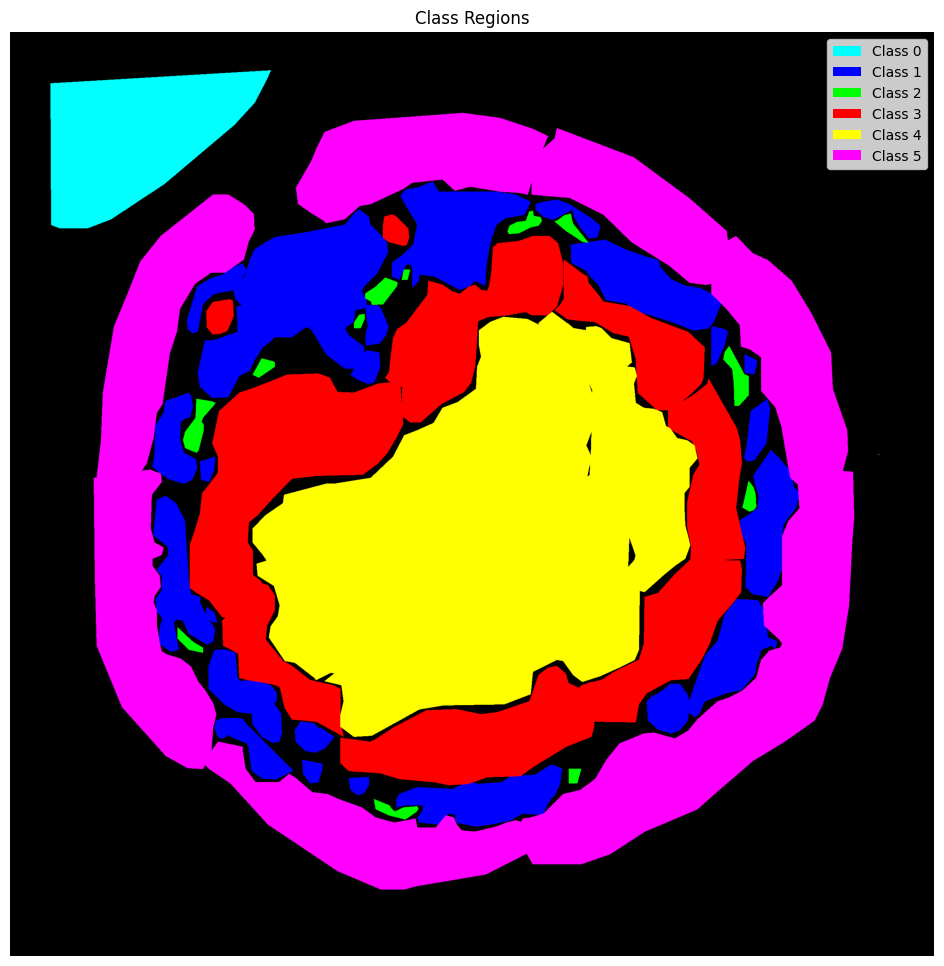


Assigning objects to classes...

Summary:
--------------------------------------------------
Class 0: 0 objects
Class 1: 207 objects
Class 2: 66 objects
Class 3: 540 objects
Class 4: 177 objects
Class 5: 1093 objects
Unassigned: 1 objects

Plotting assignment statistics...


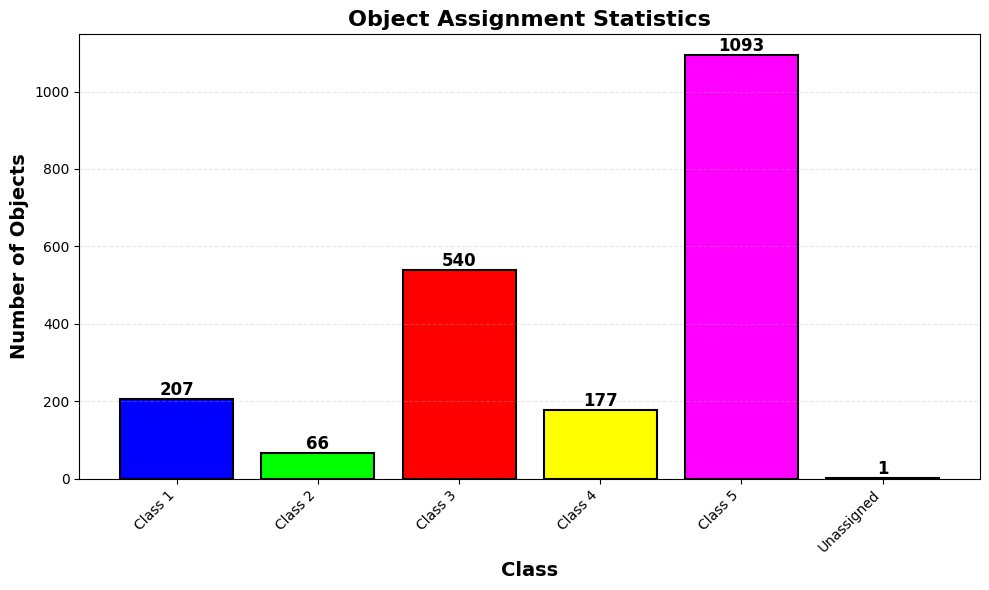


Visualizing object overlay...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-161.48477..156.67647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-64.59391..215.6706].


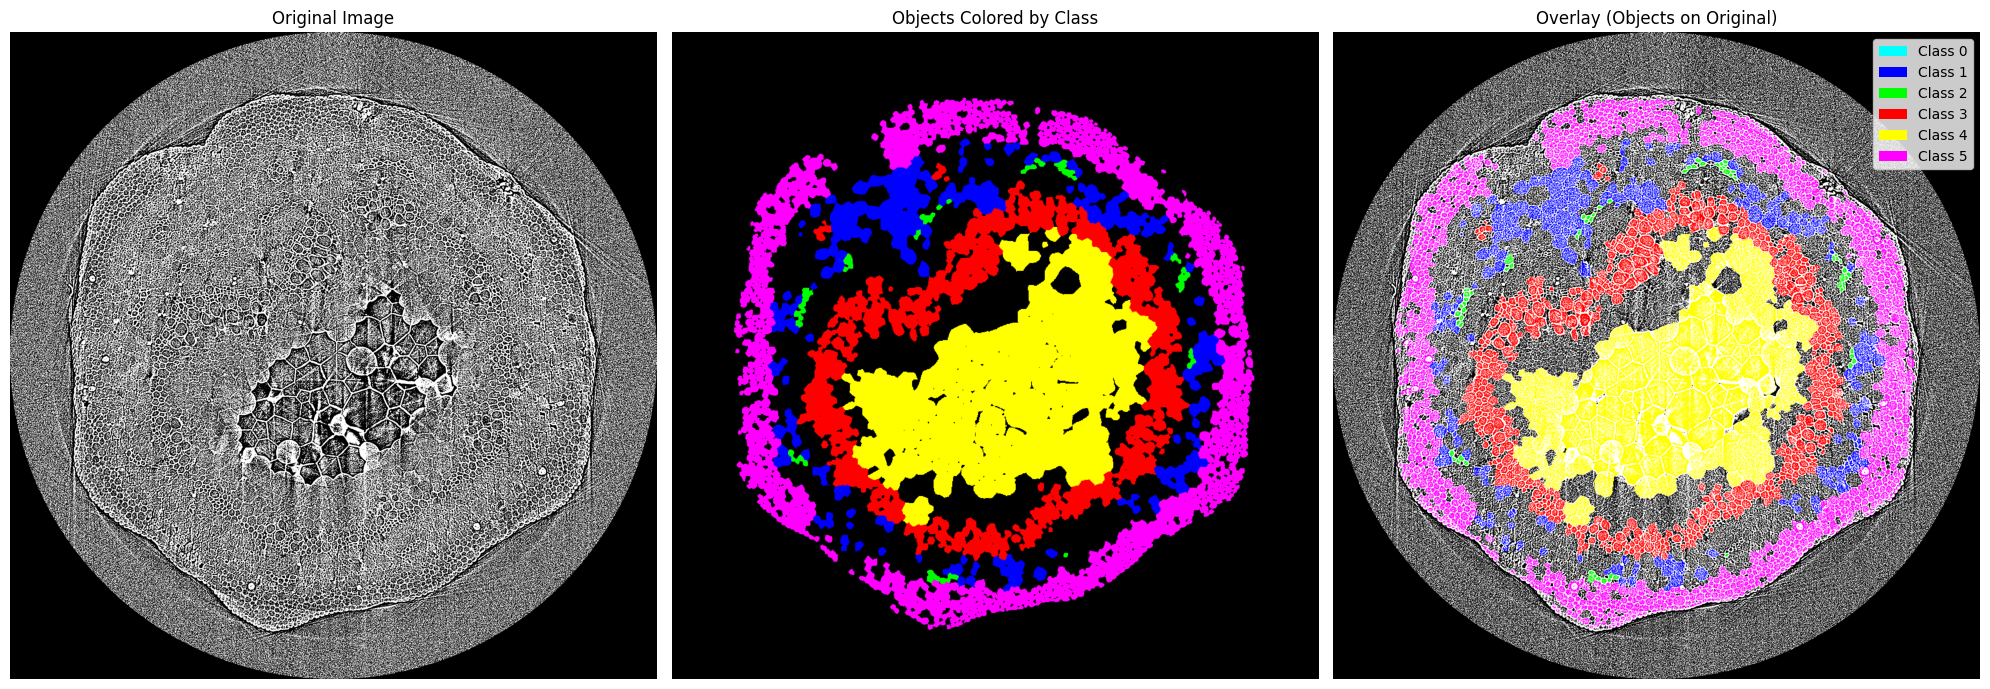

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-48.44543..182.83719].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-48.44543..182.83719].



Visualizing unassigned objects...

Unassigned object IDs: [470]


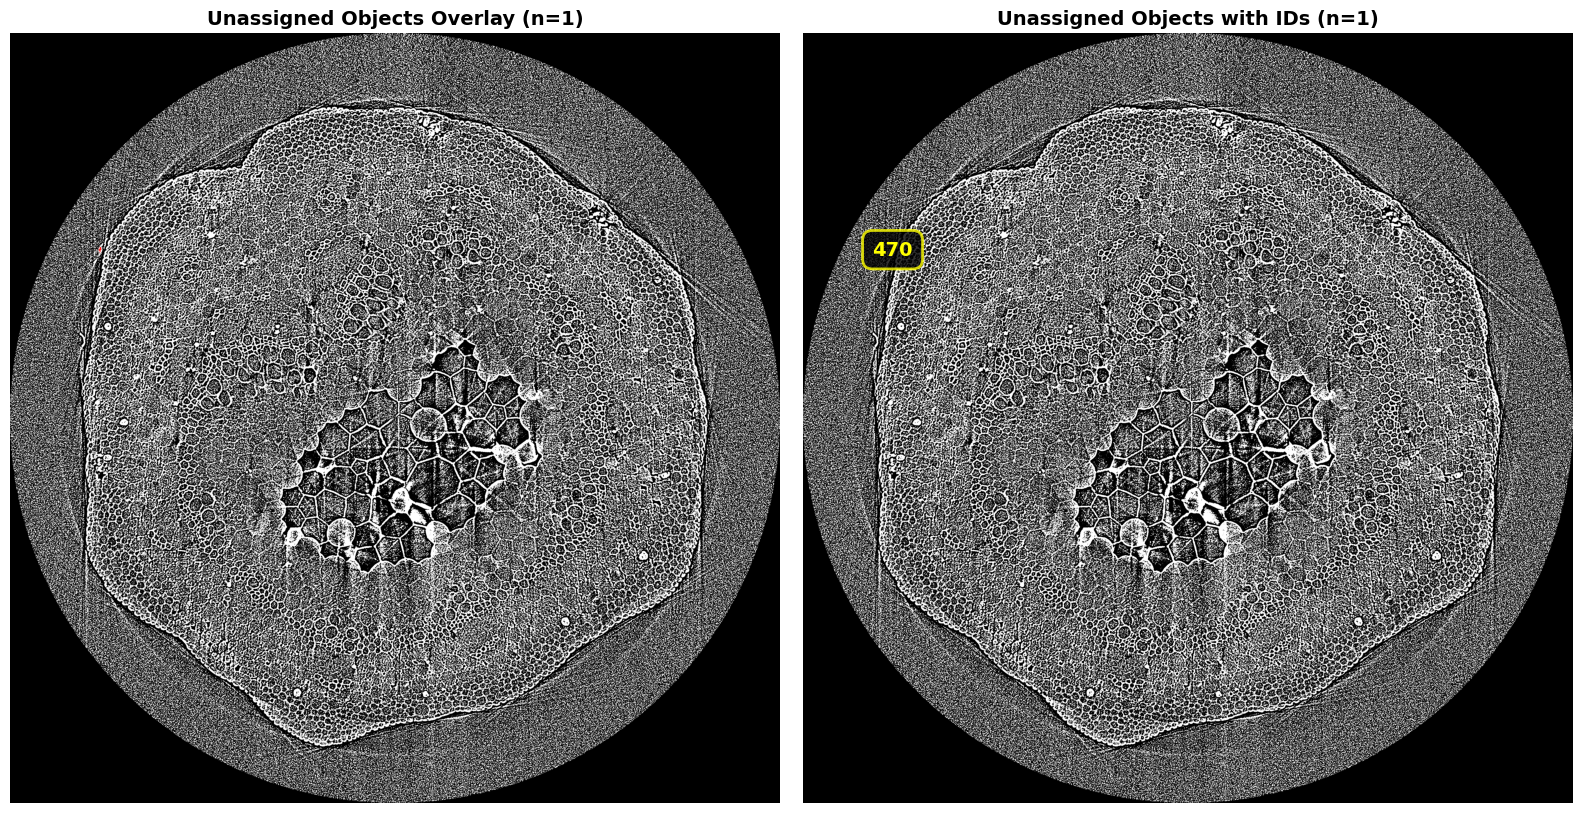


Mapping saved to: data/mappings/20211222_125057_petiole4_00012_mapping.json

Batch processing complete!
Processed: 1 files
Skipped: 0 files


In [ ]:
import numpy as np
import json
from PIL import Image
import cv2
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

def parse_svg_path(path_string):
    """
    Parse SVG path data into polygon coordinates.
    Handles 'M' (move to), 'L' (line to), and 'Z' (close path) commands.
    """
    points = []
    
    # Remove 'Z' command and clean up the path
    path_string = path_string.replace('Z', '').strip()
    
    # Split by 'M' and 'L' commands while preserving the command markers
    path_string = path_string.replace('M', ' M ').replace('L', ' L ')
    commands = path_string.split()
    
    i = 0
    while i < len(commands):
        if commands[i] == 'M' or commands[i] == 'L':
            i += 1
            if i < len(commands):
                coord_str = commands[i]
                # Remove any trailing 'Z' that might still be attached
                coord_str = coord_str.rstrip('Z')
                
                if ',' in coord_str:
                    coords = coord_str.split(',')
                    if len(coords) == 2:
                        try:
                            x, y = float(coords[0]), float(coords[1])
                            points.append([x, y])
                        except ValueError:
                            # Skip invalid coordinates
                            pass
        elif ',' in commands[i]:
            coord_str = commands[i].rstrip('Z')
            coords = coord_str.split(',')
            if len(coords) == 2:
                try:
                    x, y = float(coords[0]), float(coords[1])
                    points.append([x, y])
                except ValueError:
                    # Skip invalid coordinates
                    pass
        i += 1
    
    return np.array(points, dtype=np.int32)


def create_class_regions(image_shape, class_polygons):
    """
    Create a single mask for each class by combining all its polygons.
    
    Args:
        image_shape: tuple (height, width) of the image
        class_polygons: dict mapping class_id to list of polygon annotations
    
    Returns:
        dict mapping class_id to binary mask (region)
    """
    class_regions = {}
    
    for class_id, annotations in class_polygons.items():
        # Create empty mask for this class
        region_mask = np.zeros(image_shape, dtype=np.uint8)
        
        # Combine all polygons for this class
        for annotation in annotations:
            if 'svg_data' in annotation and 'path' in annotation['svg_data']:
                path = annotation['svg_data']['path']
                polygon = parse_svg_path(path)
                
                if len(polygon) > 0:
                    # Fill polygon on the class region mask
                    cv2.fillPoly(region_mask, [polygon], 1)
        
        class_regions[class_id] = region_mask
        print(f"Class {class_id}: Region area = {np.sum(region_mask)} pixels")
    
    return class_regions


def visualize_class_regions(class_regions):
    """
    Visualize all class regions with different colors.
    """
    if not class_regions:
        print("No class regions to visualize")
        return
    
    # Get image shape from first region
    first_region = list(class_regions.values())[0]
    h, w = first_region.shape
    
    # Create RGB visualization
    visualization = np.zeros((h, w, 3), dtype=np.uint8)
    
    # Define colors for each class - CORRECTED AFTER CLASS ID SWITCH
    # Class 0: background (cyan)
    # Class 1: cortex (blue)
    # Class 2: fibers (green)
    # Class 3: vessels (red)
    # Class 4: pith (yellow)
    # Class 5: Epidermis (magenta)
    colors = [
        [0, 255, 255],    # Cyan - background (class 0)
        [0, 0, 255],      # Blue - cortex (class 1)
        [0, 255, 0],      # Green - fibers (class 2)
        [255, 0, 0],      # Red - vessels (class 3)
        [255, 255, 0],    # Yellow - pith (class 4)
        [255, 0, 255],    # Magenta - Epidermis (class 5)
    ]
    
    # Draw each class region with its color
    for idx, (class_id, region) in enumerate(sorted(class_regions.items())):
        color = colors[idx % len(colors)]
        mask = region > 0
        visualization[mask] = color
    
    # Plot
    plt.figure(figsize=(12, 12))
    plt.imshow(visualization)
    plt.title("Class Regions")
    plt.axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=np.array(colors[i])/255, label=f'Class {class_id}')
        for i, class_id in enumerate(sorted(class_regions.keys()))
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.show()
    
    return visualization


def assign_objects_to_classes(object_mask, class_regions):
    """
    Assign class IDs to objects based on which region they fall into.
    Uses majority voting - assigns the class that covers most of the object.
    
    Args:
        object_mask: numpy array where each unique value represents an object
        class_regions: dict mapping class_id to binary mask
    
    Returns:
        dict mapping object_id to class_id
    """
    object_to_class = {}
    unique_objects = np.unique(object_mask)
    unique_objects = unique_objects[unique_objects != 0]  # Remove background
    
    for obj_id in unique_objects:
        obj_pixels = (object_mask == obj_id)
        obj_area = np.sum(obj_pixels)
        
        best_class = None
        best_overlap = 0
        
        # Check overlap with each class region
        for class_id, region_mask in class_regions.items():
            # Calculate overlap
            overlap = np.sum(obj_pixels & (region_mask > 0))
            
            if overlap > best_overlap:
                best_overlap = overlap
                best_class = class_id
        
        # Assign the class with maximum overlap
        if best_overlap > 0:
            object_to_class[int(obj_id)] = best_class
        else:
            object_to_class[int(obj_id)] = None  # No class assigned
    
    return object_to_class


def visualize_object_overlay(object_mask, object_to_class, tiff_path):
    """
    Visualize objects colored by their assigned class on top of the original image.
    """
    # Load original image
    original_img = np.array(Image.open(tiff_path))
    
    # Convert grayscale to RGB if needed
    if len(original_img.shape) == 2:
        original_img = np.stack([original_img] * 3, axis=-1)
    
    # Normalize to 0-255 if needed
    if original_img.max() <= 1.0:
        original_img = (original_img * 255).astype(np.uint8)
    
    # Define colors for each class - CORRECTED AFTER CLASS ID SWITCH
    # Class 0: background (cyan)
    # Class 1: cortex (blue)
    # Class 2: fibers (green)
    # Class 3: vessels (red)
    # Class 4: pith (yellow)
    # Class 5: Epidermis (magenta)
    class_colors = {
        '0': [0, 255, 255],    # Cyan - background
        '1': [0, 0, 255],      # Blue - cortex
        '2': [0, 255, 0],      # Green - fibers
        '3': [255, 0, 0],      # Red - vessels
        '4': [255, 255, 0],    # Yellow - pith
        '5': [255, 0, 255],    # Magenta - Epidermis
    }
    
    # Create colored object mask
    colored_objects = np.zeros_like(original_img)
    
    for obj_id, class_id in object_to_class.items():
        if class_id is not None:
            obj_pixels = (object_mask == obj_id)
            color = class_colors.get(str(class_id), [128, 128, 128])  # Gray for unknown
            colored_objects[obj_pixels] = color
    
    # Create overlay (blend original image with colored objects)
    alpha = 0.6  # Transparency of colored objects
    overlay = cv2.addWeighted(original_img, 1-alpha, colored_objects, alpha, 0)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # Original image
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Colored objects only
    axes[1].imshow(colored_objects)
    axes[1].set_title('Objects Colored by Class')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (Objects on Original)')
    axes[2].axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=np.array(class_colors.get(str(i), [128, 128, 128]))/255, 
              label=f'Class {i}')
        for i in sorted([int(k) for k in class_colors.keys()])
    ]
    axes[2].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    return overlay


def plot_assignment_stats(class_counts, unassigned_count):
    """
    Plot a bar chart showing the number of objects assigned to each class
    and the number of unassigned objects.
    """
    # Prepare data for plotting
    labels = []
    counts = []
    colors_bar = []
    
    # Define colors matching the class colors
    class_colors_plot = {
        '0': '#00FFFF',  # Cyan - background
        '1': '#0000FF',  # Blue - cortex
        '2': '#00FF00',  # Green - fibers
        '3': '#FF0000',  # Red - vessels
        '4': '#FFFF00',  # Yellow - pith
        '5': '#FF00FF',  # Magenta - Epidermis
    }
    
    # Add assigned classes
    for class_id in sorted(class_counts.keys()):
        labels.append(f'Class {class_id}')
        counts.append(class_counts[class_id])
        colors_bar.append(class_colors_plot.get(str(class_id), '#808080'))
    
    # Add unassigned objects
    if unassigned_count > 0:
        labels.append('Unassigned')
        counts.append(unassigned_count)
        colors_bar.append('#808080')  # Gray for unassigned
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(labels, counts, color=colors_bar, edgecolor='black', linewidth=1.5)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Customize plot
    ax.set_xlabel('Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Objects', fontsize=14, fontweight='bold')
    ax.set_title('Object Assignment Statistics', fontsize=16, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return fig


def visualize_unassigned_objects(object_mask, object_to_class, tiff_path):
    """
    Visualize unassigned objects and display their IDs.
    """
    # Load original image
    original_img = np.array(Image.open(tiff_path))
    
    # Convert grayscale to RGB if needed
    if len(original_img.shape) == 2:
        original_img = np.stack([original_img] * 3, axis=-1)
    
    # Normalize to 0-255 if needed
    if original_img.max() <= 1.0:
        original_img = (original_img * 255).astype(np.uint8)
    
    # Find unassigned objects
    unassigned_ids = [obj_id for obj_id, class_id in object_to_class.items() 
                      if class_id is None]
    
    if len(unassigned_ids) == 0:
        print("No unassigned objects to visualize")
        return None
    
    print(f"\nUnassigned object IDs: {unassigned_ids}")
    
    # Create mask highlighting unassigned objects
    unassigned_mask = np.zeros_like(original_img)
    
    for obj_id in unassigned_ids:
        obj_pixels = (object_mask == obj_id)
        unassigned_mask[obj_pixels] = [255, 0, 0]  # Red color for unassigned
    
    # Create overlay
    alpha = 0.7
    overlay = cv2.addWeighted(original_img, 1-alpha, unassigned_mask, alpha, 0)
    overlay_with_ids = overlay.copy()
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: Overlay WITHOUT IDs
    axes[0].imshow(overlay)
    axes[0].set_title(f'Unassigned Objects Overlay (n={len(unassigned_ids)})', 
                      fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Right: Overlay WITH IDs
    axes[1].imshow(overlay_with_ids)
    axes[1].set_title(f'Unassigned Objects with IDs (n={len(unassigned_ids)})', 
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Add object ID labels only on the right plot
    for obj_id in unassigned_ids:
        obj_pixels = (object_mask == obj_id)
        if np.any(obj_pixels):
            # Find centroid of object
            y_coords, x_coords = np.where(obj_pixels)
            centroid_y = int(np.mean(y_coords))
            centroid_x = int(np.mean(x_coords))
            
            # Add text label
            axes[1].text(centroid_x, centroid_y, str(obj_id),
                        color='yellow', fontsize=14, fontweight='bold',
                        ha='center', va='center',
                        bbox=dict(boxstyle='round,pad=0.5', 
                                facecolor='black', alpha=0.8, edgecolor='yellow', linewidth=2))
    
    plt.tight_layout()
    plt.show()
    
    return fig, unassigned_ids


def process_single_file(tiff_path, mask_tiff_path, json_path, output_dir):
    """
    Process a single set of files to assign class IDs to objects.
    
    Args:
        tiff_path: path to the original TIFF image
        mask_tiff_path: path to the object mask TIFF (with unique values per object)
        json_path: path to the annotation JSON file
        output_dir: directory to save the mapping file
    """
    print(f"\n{'='*80}")
    print(f"Processing: {Path(tiff_path).name}")
    print(f"{'='*80}")
    
    # Load the object mask
    object_mask = np.array(Image.open(mask_tiff_path))
    print(f"Object mask shape: {object_mask.shape}")
    print(f"Number of unique objects: {len(np.unique(object_mask)) - 1}")  # -1 for background
    
    # Load annotation data
    with open(json_path, 'r') as f:
        raw_data = json.load(f)
    
    # Parse the JSON structure
    class_polygons = {}
    
    if isinstance(raw_data, dict):
        # If there's a single top-level key with a list of annotations
        if len(raw_data) == 1 and isinstance(list(raw_data.values())[0], list):
            # Extract annotations and group by class_id
            annotations = list(raw_data.values())[0]
            for annotation in annotations:
                class_id = annotation.get('class_id', '0')
                if class_id not in class_polygons:
                    class_polygons[class_id] = []
                class_polygons[class_id].append(annotation)
        else:
            # Assume the structure is already {class_id: [annotations]}
            class_polygons = raw_data
    
    print(f"\nNumber of classes: {len(class_polygons)}")
    print(f"Classes found: {sorted(class_polygons.keys())}")
    
    # Create class regions by combining all polygons for each class
    print("\nCreating class regions...")
    class_regions = create_class_regions(object_mask.shape[:2], class_polygons)
    
    # Visualize the class regions
    print("\nVisualizing class regions...")
    visualize_class_regions(class_regions)
    
    # Assign objects to classes based on which region they fall in
    print("\nAssigning objects to classes...")
    object_to_class = assign_objects_to_classes(object_mask, class_regions)
    
    # Print results summary
    print("\nSummary:")
    print("-" * 50)
    
    class_counts = defaultdict(int)
    unassigned_count = 0
    
    for obj_id, class_id in object_to_class.items():
        if class_id is not None:
            class_counts[class_id] += 1
        else:
            unassigned_count += 1
    
    for class_id in sorted(class_regions.keys()):
        count = class_counts.get(class_id, 0)
        print(f"Class {class_id}: {count} objects")
    print(f"Unassigned: {unassigned_count} objects")
    
    # Plot the assignment statistics
    print("\nPlotting assignment statistics...")
    plot_assignment_stats(class_counts, unassigned_count)
    
    # Visualize objects colored by class
    print("\nVisualizing object overlay...")
    visualize_object_overlay(object_mask, object_to_class, tiff_path)
    
    # Visualize unassigned objects
    if unassigned_count > 0:
        print("\nVisualizing unassigned objects...")
        visualize_unassigned_objects(object_mask, object_to_class, tiff_path)
    
    # Save results (only mapping JSON)
    base_name = Path(tiff_path).stem
    output_path = output_dir / f"{base_name}_mapping.json"
    with open(output_path, 'w') as f:
        json.dump(object_to_class, f, indent=2)
    
    print(f"\nMapping saved to: {output_path}")
    
    return object_to_class, class_regions


def batch_process(images_dir, masks_dir, annotations_dir, mappings_dir):
    """
    Process all matching files in the specified directories.
    
    Args:
        images_dir: directory containing image files (.tiff or .tif)
        masks_dir: directory containing mask files (*_masks.tif or *_masks.tiff)
        annotations_dir: directory containing annotation files (*_annotations.json)
        mappings_dir: directory to save mapping files
    """
    # Create output directory if it doesn't exist
    mappings_dir = Path(mappings_dir)
    mappings_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    images_dir = Path(images_dir)
    image_files = list(images_dir.glob("*.tiff")) + list(images_dir.glob("*.tif"))
    
    print(f"Found {len(image_files)} image files")
    
    processed_count = 0
    skipped_count = 0
    
    for image_path in sorted(image_files):
        base_name = image_path.stem
        
        # Find corresponding mask file
        masks_dir_path = Path(masks_dir)
        mask_path = masks_dir_path / f"{base_name}_masks.tif"
        if not mask_path.exists():
            mask_path = masks_dir_path / f"{base_name}_masks.tiff"
        
        # Find corresponding annotation file
        annotations_dir_path = Path(annotations_dir)
        annotation_path = annotations_dir_path / f"{base_name}_annotations.json"
        
        # Check if all files exist
        if not mask_path.exists():
            print(f"\nSkipping {base_name}: mask file not found")
            skipped_count += 1
            continue
        
        if not annotation_path.exists():
            print(f"\nSkipping {base_name}: annotation file not found")
            skipped_count += 1
            continue
        
        # Process the files
        try:
            process_single_file(image_path, mask_path, annotation_path, mappings_dir)
            processed_count += 1
        except Exception as e:
            print(f"\nError processing {base_name}: {str(e)}")
            skipped_count += 1
    
    print(f"\n{'='*80}")
    print(f"Batch processing complete!")
    print(f"Processed: {processed_count} files")
    print(f"Skipped: {skipped_count} files")
    print(f"{'='*80}")


if __name__ == "__main__":
    # Batch process all files
    images_dir = "./data/images"
    masks_dir = "./data/instance_masks"
    annotations_dir = "./data/annotations"
    mappings_dir = "./data/mappings"
    
    batch_process(images_dir, masks_dir, annotations_dir, mappings_dir)

In [5]:
import json
from pathlib import Path
from collections import defaultdict

def process_mapping_file(mapping_path):
    """
    Process a single mapping file: change null classes to '0' and save as _corrected.json
    
    Args:
        mapping_path: path to the mapping JSON file
    """
    base_name = mapping_path.stem
    
    print(f"\n{'='*80}")
    print(f"Processing: {mapping_path.name}")
    print(f"{'='*80}")
    
    # Load the object class mapping
    with open(mapping_path, 'r') as f:
        object_to_class = json.load(f)
    
    print(f"Total objects in mapping: {len(object_to_class)}")
    
    # Count objects before update
    null_count = 0
    for obj_id, class_id in object_to_class.items():
        if class_id is None or class_id == 'null':
            null_count += 1
    
    print(f"Objects with null class: {null_count}")
    
    # Update the mapping - change all null to class '0'
    updated_count = 0
    for obj_id, class_id in object_to_class.items():
        if class_id is None or class_id == 'null':
            object_to_class[obj_id] = '0'
            updated_count += 1
    
    print(f"Updated {updated_count} objects from null to class '0'")
    
    # Save the updated mapping to a new file with _corrected suffix
    output_path = mapping_path.parent / f"{base_name}_corrected{mapping_path.suffix}"
    
    with open(output_path, 'w') as f:
        json.dump(object_to_class, f, indent=2)
    
    print(f"\n✓ Updated mapping saved to: {output_path}")
    
    # Print summary statistics
    class_counts = defaultdict(int)
    unassigned_count = 0
    
    for obj_id, class_id in object_to_class.items():
        if class_id is not None and class_id != 'null':
            class_counts[class_id] += 1
        else:
            unassigned_count += 1
    
    print("\nUpdated class distribution:")
    print("-" * 50)
    for class_id in sorted(class_counts.keys()):
        count = class_counts[class_id]
        print(f"Class {class_id}: {count} objects")
    if unassigned_count > 0:
        print(f"Unassigned: {unassigned_count} objects")
    
    return updated_count


def batch_process_mappings(mappings_dir):
    """
    Process all mapping JSON files in the specified directory.
    
    Args:
        mappings_dir: directory containing mapping JSON files
    """
    mappings_dir = Path(mappings_dir)
    
    # Get all JSON files that don't already end with _corrected.json
    mapping_files = [f for f in mappings_dir.glob("*.json") 
                     if not f.stem.endswith("_corrected")]
    
    print(f"Found {len(mapping_files)} mapping files to process")
    
    processed_count = 0
    total_updated_objects = 0
    
    for mapping_path in sorted(mapping_files):
        try:
            updated_count = process_mapping_file(mapping_path)
            total_updated_objects += updated_count
            processed_count += 1
        except Exception as e:
            print(f"\nError processing {mapping_path.name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    print(f"\n{'='*80}")
    print("Batch processing complete!")
    print(f"Processed: {processed_count} files")
    print(f"Total objects updated from null to class '0': {total_updated_objects}")
    print(f"{'='*80}")


if __name__ == "__main__":
    # Process all mapping files in the folder
    mappings_dir = "./data/mappings/"
    
    batch_process_mappings(mappings_dir)

Found 1 mapping files to process

Processing: 20211222_125057_petiole4_00012_mapping.json
Total objects in mapping: 2084
Objects with null class: 1
Updated 1 objects from null to class '0'

✓ Updated mapping saved to: data/mappings/20211222_125057_petiole4_00012_mapping_corrected.json

Updated class distribution:
--------------------------------------------------
Class 0: 1 objects
Class 1: 207 objects
Class 2: 66 objects
Class 3: 540 objects
Class 4: 177 objects
Class 5: 1093 objects

Batch processing complete!
Processed: 1 files
Total objects updated from null to class '0': 1


In [6]:
import numpy as np
import json
from PIL import Image
from pathlib import Path
from collections import defaultdict
import cv2

def process_single_file(image_path, mask_path, mapping_path, output_dir):
    """
    Process a single set of files and generate two .txt files.
    
    Args:
        image_path: path to the original TIFF image
        mask_path: path to the object mask TIFF
        mapping_path: path to the corrected mapping JSON file
        output_dir: directory to save the .txt files
    """
    base_name = Path(image_path).stem
    
    print(f"\n{'='*80}")
    print(f"Processing: {base_name}")
    print(f"{'='*80}")
    
    print("Loading files...")
    original_img = np.array(Image.open(image_path))
    object_mask = np.array(Image.open(mask_path))
    
    with open(mapping_path, 'r') as f:
        object_to_class = json.load(f)
    
    print(f"Image shape: {original_img.shape}")
    print(f"Mask shape: {object_mask.shape}")
    print(f"Total objects in mapping: {len(object_to_class)}")
    
    # Count objects by category
    class_counts = defaultdict(int)
    category_names = {
        '0': 'Background',
        '1': 'Cortex',
        '2': 'Phloem Fibers',
        '3': 'Xylem Vessels',
        '4': 'Pith Cells',
        '5': 'Epidermis'
    }
    
    for obj_id, class_id in object_to_class.items():
        if class_id is not None and class_id != 'null':
            class_counts[class_id] += 1
    
    total_annotated = sum(class_counts.values())
    
    print(f"\nTotal annotated objects: {total_annotated}")
    for class_id in sorted(class_counts.keys()):
        count = class_counts[class_id]
        name = category_names.get(class_id, f'Class {class_id}')
        print(f"Category {class_id} ({name}): {count} objects")
    
    # Get all unique objects from mask
    unique_objects = np.unique(object_mask)
    unique_objects = unique_objects[unique_objects != 0]  # Remove background
    total_objects = len(unique_objects)
    
    print(f"\nTotal objects in mask: {total_objects}")
    
    # ========== File 1: object_class_mapping.txt ==========
    output_path1 = output_dir / f"{base_name}_object_class_mapping.txt"
    with open(output_path1, 'w') as f:
        f.write("ObjectID\tClassID\n")
        
        # Write only annotated objects (those with class assignments)
        for obj_id, class_id in sorted(object_to_class.items(), key=lambda x: int(x[0])):
            if class_id is not None and class_id != 'null':
                f.write(f"{obj_id}\t{class_id}\n")
    
    print(f"\n✓ Saved File 1: {output_path1}")
    print(f"  Format: ObjectID, ClassID")
    print(f"  Total objects: {total_annotated}")
    
    # ========== File 2: object_geometry.txt ==========
    print("\nExtracting object geometries...")
    output_path2 = output_dir / f"{base_name}_object_geometry.txt"
    
    with open(output_path2, 'w') as f:
        f.write("ObjectID\tPolygon\tBBox\n")
        
        for obj_id in unique_objects:
            # Create binary mask for this object
            obj_pixels = (object_mask == obj_id).astype(np.uint8)
            
            # Find contours
            contours, _ = cv2.findContours(obj_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if len(contours) > 0:
                # Get the largest contour
                contour = max(contours, key=cv2.contourArea)
                
                # Extract polygon coordinates
                polygon_points = contour.squeeze()
                
                # Handle single point or line cases
                if polygon_points.ndim == 1:
                    polygon_points = polygon_points.reshape(1, -1)
                
                # Format polygon as "x1,y1;x2,y2;..."
                polygon_str = ";".join([f"{pt[0]},{pt[1]}" for pt in polygon_points])
                
                # Get bounding box in x1,y1,x2,y2 format
                x, y, w, h = cv2.boundingRect(contour)
                x1, y1 = x, y
                x2, y2 = x + w, y + h
                bbox_str = f"{x1},{y1},{x2},{y2}"
                
                # Write to file with tab separation
                f.write(f"{obj_id}\t{polygon_str}\t{bbox_str}\n")
    
    print(f"\n✓ Saved File 2: {output_path2}")
    print(f"  Format: ObjectID, Polygon, BBox")
    print(f"  Total objects: {total_objects}")
    
    return total_annotated, total_objects


def batch_process(images_dir, masks_dir, mappings_dir, meta_dir):
    """
    Process all matching files in the specified directories.
    
    Args:
        images_dir: directory containing image files (.tiff or .tif)
        masks_dir: directory containing mask files (*_masks.tif or *_masks.tiff)
        mappings_dir: directory containing corrected mapping files (*_corrected.json)
        meta_dir: directory to save the .txt metadata files
    """
    # Create output directory if it doesn't exist
    meta_dir = Path(meta_dir)
    meta_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    images_dir = Path(images_dir)
    image_files = list(images_dir.glob("*.tiff")) + list(images_dir.glob("*.tif"))
    
    print(f"Found {len(image_files)} image files")
    
    processed_count = 0
    skipped_count = 0
    
    for image_path in sorted(image_files):
        base_name = image_path.stem
        
        # Find corresponding mask file
        masks_dir_path = Path(masks_dir)
        mask_path = masks_dir_path / f"{base_name}_masks.tif"
        if not mask_path.exists():
            mask_path = masks_dir_path / f"{base_name}_masks.tiff"
        
        # Find corresponding corrected mapping file
        mappings_dir_path = Path(mappings_dir)
        mapping_path = mappings_dir_path / f"{base_name}_mapping_corrected.json"
        
        # Check if all files exist
        if not mask_path.exists():
            print(f"\nSkipping {base_name}: mask file not found")
            skipped_count += 1
            continue
        
        if not mapping_path.exists():
            print(f"\nSkipping {base_name}: corrected mapping file not found")
            skipped_count += 1
            continue
        
        # Process the files
        try:
            process_single_file(image_path, mask_path, mapping_path, meta_dir)
            processed_count += 1
        except Exception as e:
            print(f"\nError processing {base_name}: {str(e)}")
            import traceback
            traceback.print_exc()
            skipped_count += 1
    
    print(f"\n{'='*80}")
    print("Batch processing complete!")
    print(f"Processed: {processed_count} files")
    print(f"Skipped: {skipped_count} files")
    print(f"Output directory: {meta_dir}")
    print(f"{'='*80}")


if __name__ == "__main__":
    # Batch process all files
    images_dir = "./data/images"
    masks_dir = "./data/instance_masks"
    mappings_dir = "./data/mappings"
    meta_dir = "./data/meta"
    
    batch_process(images_dir, masks_dir, mappings_dir, meta_dir)

Found 1 image files

Processing: 20211222_125057_petiole4_00012
Loading files...
Image shape: (2560, 2560)
Mask shape: (2560, 2560)
Total objects in mapping: 2084

Total annotated objects: 2084
Category 0 (Background): 1 objects
Category 1 (Cortex): 207 objects
Category 2 (Phloem Fibers): 66 objects
Category 3 (Xylem Vessels): 540 objects
Category 4 (Pith Cells): 177 objects
Category 5 (Epidermis): 1093 objects

Total objects in mask: 2084

✓ Saved File 1: data/meta/20211222_125057_petiole4_00012_object_class_mapping.txt
  Format: ObjectID, ClassID
  Total objects: 2084

Extracting object geometries...

✓ Saved File 2: data/meta/20211222_125057_petiole4_00012_object_geometry.txt
  Format: ObjectID, Polygon, BBox
  Total objects: 2084

Batch processing complete!
Processed: 1 files
Skipped: 0 files
Output directory: data/meta


In [7]:
from pathlib import Path

def process_file_pair(mapping_file, geometry_file):
    """
    Process a pair of mapping and geometry files to remove class 0 objects.
    
    Args:
        mapping_file: path to object_class_mapping.txt
        geometry_file: path to object_geometry.txt
    """
    base_name = mapping_file.stem.replace("_object_class_mapping", "")
    
    print(f"\n{'='*80}")
    print(f"Processing: {base_name}")
    print(f"{'='*80}")
    
    # ========== Clean object_class_mapping.txt ==========
    print("Cleaning object_class_mapping.txt...")
    
    # First pass: identify objects with class 0
    class_0_objects = set()
    with open(mapping_file, 'r') as f:
        header = f.readline()  # Skip header
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                obj_id = parts[0]
                class_id = parts[1]
                if class_id == '0':
                    class_0_objects.add(obj_id)
    
    print(f"Found {len(class_0_objects)} objects with class ID 0")
    
    # Second pass: write cleaned file
    cleaned_lines = []
    removed_count = 0
    
    with open(mapping_file, 'r') as f:
        header = f.readline()
        cleaned_lines.append(header)
        
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                class_id = parts[1]
                if class_id != '0':
                    cleaned_lines.append(line)
                else:
                    removed_count += 1
    
    output_mapping = mapping_file.parent / f"{base_name}_object_class_mapping_cleaned.txt"
    with open(output_mapping, 'w') as f:
        f.writelines(cleaned_lines)
    
    print(f"✓ Removed {removed_count} objects from mapping file")
    print(f"✓ Saved to: {output_mapping}")
    
    # ========== Clean object_geometry.txt ==========
    print("\nCleaning object_geometry.txt...")
    cleaned_lines = []
    removed_count = 0
    
    with open(geometry_file, 'r') as f:
        header = f.readline()
        cleaned_lines.append(header)
        
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 1:
                obj_id = parts[0]
                if obj_id not in class_0_objects:
                    cleaned_lines.append(line)
                else:
                    removed_count += 1
    
    output_geometry = geometry_file.parent / f"{base_name}_object_geometry_cleaned.txt"
    with open(output_geometry, 'w') as f:
        f.writelines(cleaned_lines)
    
    print(f"✓ Removed {removed_count} objects from geometry file")
    print(f"✓ Saved to: {output_geometry}")
    
    return len(class_0_objects)


def batch_clean_meta(meta_dir):
    """
    Process all txt file pairs in the meta directory to remove class 0 objects.
    
    Args:
        meta_dir: directory containing the txt metadata files
    """
    meta_dir = Path(meta_dir)
    
    # Find all object_class_mapping.txt files (excluding _cleaned versions)
    mapping_files = [f for f in meta_dir.glob("*_object_class_mapping.txt")
                     if not f.stem.endswith("_cleaned")]
    
    print(f"Found {len(mapping_files)} mapping files to process")
    
    processed_count = 0
    total_removed_objects = 0
    
    for mapping_file in sorted(mapping_files):
        # Find corresponding geometry file
        base_name = mapping_file.stem.replace("_object_class_mapping", "")
        geometry_file = meta_dir / f"{base_name}_object_geometry.txt"
        
        if not geometry_file.exists():
            print(f"\nSkipping {base_name}: geometry file not found")
            continue
        
        try:
            removed_count = process_file_pair(mapping_file, geometry_file)
            total_removed_objects += removed_count
            processed_count += 1
        except Exception as e:
            print(f"\nError processing {base_name}: {str(e)}")
            import traceback
            traceback.print_exc()
    
    print(f"\n{'='*80}")
    print("Batch cleaning complete!")
    print(f"Processed: {processed_count} file pairs")
    print(f"Total objects with class 0 removed: {total_removed_objects}")
    print(f"{'='*80}")


if __name__ == "__main__":
    # Process all txt files in the meta folder
    meta_dir = "./data/meta"
    
    batch_clean_meta(meta_dir)

Found 1 mapping files to process

Processing: 20211222_125057_petiole4_00012
Cleaning object_class_mapping.txt...
Found 1 objects with class ID 0
✓ Removed 1 objects from mapping file
✓ Saved to: data/meta/20211222_125057_petiole4_00012_object_class_mapping_cleaned.txt

Cleaning object_geometry.txt...
✓ Removed 1 objects from geometry file
✓ Saved to: data/meta/20211222_125057_petiole4_00012_object_geometry_cleaned.txt

Batch cleaning complete!
Processed: 1 file pairs
Total objects with class 0 removed: 1
